In [1]:
import sys
sys.path.insert(0,'./')
from cityscapes import CityScapes

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

import os
import os.path as osp
import logging
import time
import datetime
from shelfnet import ShelfNet

In [2]:
# Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))


def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")


In [3]:
# training dataset
n_classes = 19
batch = 4
n_workers = 4
cropsize = [1024, 1024] # [h, w] of the cropped image
ds_train = CityScapes('data/', cropsize=cropsize, mode='train')
dl_train = DataLoader(ds_train,
                batch_size = batch,
                shuffle = True,
                num_workers = n_workers,
                pin_memory = True,
                drop_last = True)

# iterate through the dataset
for i, (imgs, label) in enumerate(dl_train):
    print(imgs.shape, label.shape)
    break

torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


Goal is to simplify the model even further by reducing the channels more

Below is the format of the realtime shelfnet 18

```python
class ShelfNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(ShelfNet, self).__init__()
        self.backbone = Resnet18()

        self.decoder = Decoder(planes=64,layers=3,kernel=3)
        self.ladder = LadderBlock(planes=64,layers=3, kernel=3)

        self.conv_out = NetOutput(64, 64, n_classes)
        self.conv_out16 = NetOutput(128, 64, n_classes)
        self.conv_out32 = NetOutput(256, 64, n_classes)

        self.trans1 = ConvBNReLU(128,64,ks=1,stride=1,padding=0)
        self.trans2 = ConvBNReLU(256, 128, ks=1, stride=1, padding=0)
        self.trans3 = ConvBNReLU(512, 256, ks=1, stride=1, padding=0)
    def forward(self, x, aux = True):
        H, W = x.size()[2:]

        feat8, feat16, feat32 = self.backbone(x)

        feat8 = self.trans1(feat8)
        feat16 = self.trans2(feat16)
        feat32 = self.trans3(feat32)

        out = self.decoder([feat8, feat16, feat32])

        out2 = self.ladder(out)

        feat_cp8, feat_cp16, feat_cp32 = out2[-1], out2[-2], out2[-3]

        feat_out = self.conv_out(feat_cp8)
        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)

        if aux:
            feat_out16 = self.conv_out16(feat_cp16)
            feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)

            feat_out32 = self.conv_out32(feat_cp32)
            feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)

            return feat_out, feat_out16, feat_out32
        else:
            return feat_out

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, LadderBlock) or isinstance(child, NetOutput) or isinstance(child, Decoder)\
                    or isinstance(child, ConvBNReLU):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params
```

### define the reduced channel model version

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from resnet2 import resnet18
from modules.bn import InPlaceABNSync
from ShelfBlock import Decoder, LadderBlock
from shelfnet import ConvBNReLU, NetOutput

class SimpleShelfNet(nn.Module):
    def __init__(self, n_classes, channel_ratio=0.25):
        # Add channel_ratio for control of decoder channels
        super(SimpleShelfNet, self).__init__()

        self.backbone = resnet18()

        # Reduce decoder channels by channel_ratio
        self.decoder = Decoder(planes=int(64 * channel_ratio), layers=3, kernel=3)
        self.ladder = LadderBlock(planes=int(64 * channel_ratio), layers=3, kernel=3)

        self.conv_out = NetOutput(int(64 * channel_ratio), 64, n_classes)
        self.conv_out16 = NetOutput(int(128 * channel_ratio), 64, n_classes)
        self.conv_out32 = NetOutput(int(256 * channel_ratio), 64, n_classes)

        # Adjust transition layers if decoder channels are reduced
        self.trans1 = ConvBNReLU(128, int(64 * channel_ratio), ks=1, stride=1, padding=0)
        self.trans2 = ConvBNReLU(256, int(128 * channel_ratio), ks=1, stride=1, padding=0)
        self.trans3 = ConvBNReLU(512, int(256 * channel_ratio), ks=1, stride=1, padding=0)
        
    def forward(self, x, aux = True):
        H, W = x.size()[2:]

        feat8, feat16, feat32 = self.backbone(x)

        feat8 = self.trans1(feat8)
        feat16 = self.trans2(feat16)
        feat32 = self.trans3(feat32)

        out = self.decoder([feat8, feat16, feat32])

        out2 = self.ladder(out)

        feat_cp8, feat_cp16, feat_cp32 = out2[-1], out2[-2], out2[-3]

        feat_out = self.conv_out(feat_cp8)
        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)

        if aux:
            feat_out16 = self.conv_out16(feat_cp16)
            feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)

            feat_out32 = self.conv_out32(feat_cp32)
            feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)

            return feat_out, feat_out16, feat_out32
        else:
            return feat_out

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, LadderBlock) or isinstance(child, NetOutput) or isinstance(child, Decoder)\
                    or isinstance(child, ConvBNReLU):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params

### model architecture

In [5]:
# simple model
simple_model = SimpleShelfNet(n_classes=n_classes, channel_ratio=.25).cuda()

view_network_shapes(simple_model, torch.Size([1, 3, cropsize[0], cropsize[1]])) # batch size is 8, but see pass through of 1 image at a time

Layer (type:depth-idx)                             Output Shape              Param #
SimpleShelfNet                                     [1, 19, 1024, 1024]       --
├─ResNet: 1-1                                      [1, 128, 128, 128]        513,000
│    └─Conv2d: 2-1                                 [1, 64, 512, 512]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 512, 512]         128
│    └─MaxPool2d: 2-3                              [1, 64, 256, 256]         --
│    └─Sequential: 2-4                             [1, 64, 256, 256]         --
│    │    └─BasicBlock: 3-1                        [1, 64, 256, 256]         73,984
│    │    └─BasicBlock: 3-2                        [1, 64, 256, 256]         73,984
│    └─Sequential: 2-5                             [1, 128, 128, 128]        --
│    │    └─BasicBlock: 3-3                        [1, 128, 128, 128]        230,144
│    │    └─BasicBlock: 3-4                        [1, 128, 128, 128]        295,424
│    └─S

### Checking Runtime

In [6]:
# load weights
simple_model.eval()
run_time = []

# measure inference time via random input
for i in range(0,100):
    input = torch.randn(1,3,1024,1024).cuda()
    # ensure that context initialization and normal_() operations
    # finish before you start measuring time
    torch.cuda.synchronize()
    torch.cuda.synchronize()
    start = time.perf_counter()

    with torch.no_grad():
        output = simple_model(input , aux=False)

    torch.cuda.synchronize()  # wait for mm to finish
    end = time.perf_counter()

    run_time.append(end-start)

print('Mean running time is ', np.mean(run_time))

Mean running time is  0.012002318389986612


### Training the models

The following is a modified version of their training

In [7]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [8]:
from loss import OhemCELoss
from optimizer import Optimizer
from tqdm import tqdm
from evaluate import MscEval
import json

respth = './res'

## model
ignore_idx = 255
net = SimpleShelfNet(n_classes=n_classes, channel_ratio=.25)
net.cuda()
net.train()
score_thres = 0.7
n_min = batch*cropsize[0]*cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

## optimizer
max_iter = 2000
learning_rate = 0.0001
weight_decay = 5e-4
optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

## train loop
msg_iter = 50
save_iter = 500
loss_iters1 = []
loss_avg = []
st = glob_st = time.time()
diter = iter(dl_train)
epoch = 0
for it in range(max_iter):
    try:
        im, lb = next(diter)
    except StopIteration:
        epoch += 1
        diter = iter(dl_train)
        im, lb = next(diter)

    im = im.cuda()
    lb = lb.cuda()
    H, W = im.size()[2:]
    lb = torch.squeeze(lb, 1)

    optim.zero_grad()
    out, out16, out32 = net(im)
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    loss.backward()
    optim.step()

    loss_avg.append(loss.item())

    ## print training log message
    if (it+1)%msg_iter==0:
        loss_avg = sum(loss_avg) / len(loss_avg)
        loss_iters1.append(loss_avg)
        ed = time.time()
        t_intv, glob_t_intv = ed - st, ed - glob_st
        eta = int((max_iter - it) * (glob_t_intv / it))
        eta = str(datetime.timedelta(seconds=eta))
        msg = ', '.join([
                'it: {it}/{max_it}',
                'loss: {loss:.4f}',
                'eta: {eta}',
                'time: {time:.4f}',
            ]).format(
                it = it+1,
                max_it = max_iter,
                loss = loss_avg,
                time = t_intv,
                eta = eta
            )
        print(msg)
        loss_avg = []
        st = ed

    gc.collect()

    if (it+1) % save_iter == 0:
        ## dump the models in between
        save_pth = osp.join(respth, 'shelfnet_model_it_%d.pth'%it)
        torch.save(net.state_dict(), save_pth)

        list_json = osp.join(respth, 'loss_%d.json'%it)
        with open(list_json, 'w') as f:
            json.dump(loss_iters1, f, indent=2) 


## dump the final model
save_pth = osp.join(respth, 'model_final.pth')
net.cpu()
state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
torch.save(state, save_pth)
print('training done, model saved to: {}'.format(save_pth))

it: 50/2000, loss: 7.2412, eta: 0:18:44, time: 28.2504
it: 100/2000, loss: 5.8352, eta: 0:17:18, time: 25.8370
it: 150/2000, loss: 5.4252, eta: 0:16:35, time: 26.0873
it: 200/2000, loss: 5.0413, eta: 0:16:01, time: 26.0248
it: 250/2000, loss: 4.9988, eta: 0:15:27, time: 25.6656
it: 300/2000, loss: 4.7699, eta: 0:14:55, time: 25.5432
it: 350/2000, loss: 4.7052, eta: 0:14:25, time: 25.5153
it: 400/2000, loss: 4.5092, eta: 0:13:57, time: 25.7378
it: 450/2000, loss: 4.6680, eta: 0:13:29, time: 25.6204
it: 500/2000, loss: 4.5769, eta: 0:13:02, time: 25.8400
it: 550/2000, loss: 4.3311, eta: 0:12:35, time: 25.9124
it: 600/2000, loss: 4.3190, eta: 0:12:09, time: 25.9471
it: 650/2000, loss: 4.6946, eta: 0:11:43, time: 26.0151
it: 700/2000, loss: 4.5169, eta: 0:11:17, time: 26.0938
it: 750/2000, loss: 4.4246, eta: 0:10:53, time: 27.4338
it: 800/2000, loss: 4.3730, eta: 0:10:27, time: 26.0422
it: 850/2000, loss: 4.3056, eta: 0:10:01, time: 26.2530
it: 900/2000, loss: 4.2101, eta: 0:09:35, time: 2

Now compare the training against the original over 2,000 iterations

In [7]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [8]:
from loss import OhemCELoss
from tqdm import tqdm
import json

respth = './resOG'

## model for original realtime model
ignore_idx = 255
net = ShelfNet(n_classes=n_classes)
net.cuda()
net.train()
score_thres = 0.7
n_min = batch*cropsize[0]*cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

## optimizer
max_iter = 2000
learning_rate = 0.0001
weight_decay = 5e-4
optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

## train loop
msg_iter = 50
save_iter = 500
loss_iters2 = []
miou_iters = []
loss_avg = []
st = glob_st = time.time()
diter = iter(dl_train)
epoch = 0
for it in range(max_iter):
    try:
        im, lb = next(diter)
    except StopIteration:
        epoch += 1
        diter = iter(dl_train)
        im, lb = next(diter)

    im = im.cuda()
    lb = lb.cuda()
    H, W = im.size()[2:]
    lb = torch.squeeze(lb, 1)

    optim.zero_grad()
    out, out16, out32 = net(im)
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    loss.backward()
    optim.step()

    loss_avg.append(loss.item())

    ## print training log message
    if (it+1)%msg_iter==0:
        loss_avg = sum(loss_avg) / len(loss_avg)
        loss_iters2.append(loss_avg)
        ed = time.time()
        t_intv, glob_t_intv = ed - st, ed - glob_st
        eta = int((max_iter - it) * (glob_t_intv / it))
        eta = str(datetime.timedelta(seconds=eta))
        msg = ', '.join([
                'it: {it}/{max_it}',
                'loss: {loss:.4f}',
                'eta: {eta}',
                'time: {time:.4f}',
            ]).format(
                it = it+1,
                max_it = max_iter,
                loss = loss_avg,
                time = t_intv,
                eta = eta
            )
        print(msg)
        loss_avg = []
        st = ed

    gc.collect()

    if (it+1) % save_iter == 0:
        ## dump the models in between
        save_pth = osp.join(respth, 'shelfnet_model_it_%d.pth'%it)
        torch.save(net.state_dict(), save_pth)

        list_json = osp.join(respth, 'loss_%d.json'%it)
        with open(list_json, 'w') as f:
            json.dump(loss_iters2, f, indent=2) 


## dump the final model
save_pth = osp.join(respth, 'model_final.pth')
net.cpu()
state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
torch.save(state, save_pth)
print('training done, model saved to: {}'.format(save_pth))

it: 50/2000, loss: 5.7970, eta: 0:19:54, time: 29.9929
it: 100/2000, loss: 4.7950, eta: 0:18:14, time: 27.0213
it: 150/2000, loss: 4.2767, eta: 0:17:22, time: 26.8962
it: 200/2000, loss: 4.2966, eta: 0:16:43, time: 26.9178
it: 250/2000, loss: 4.1247, eta: 0:16:07, time: 26.7606
it: 300/2000, loss: 4.1438, eta: 0:15:35, time: 26.9167
it: 350/2000, loss: 3.9069, eta: 0:15:04, time: 26.7136
it: 400/2000, loss: 4.0978, eta: 0:14:34, time: 26.7254
it: 450/2000, loss: 4.0669, eta: 0:14:05, time: 26.7331
it: 500/2000, loss: 3.9529, eta: 0:13:36, time: 26.7535
it: 550/2000, loss: 4.0686, eta: 0:13:09, time: 27.1768
it: 600/2000, loss: 3.8951, eta: 0:12:40, time: 26.7073
it: 650/2000, loss: 3.7573, eta: 0:12:12, time: 26.7447
it: 700/2000, loss: 3.8199, eta: 0:11:45, time: 26.8810
it: 750/2000, loss: 3.7067, eta: 0:11:19, time: 27.8443
it: 800/2000, loss: 3.7308, eta: 0:10:51, time: 26.8028
it: 850/2000, loss: 3.7229, eta: 0:10:24, time: 26.7459
it: 900/2000, loss: 3.6918, eta: 0:09:56, time: 2

### plotting losses over iterations

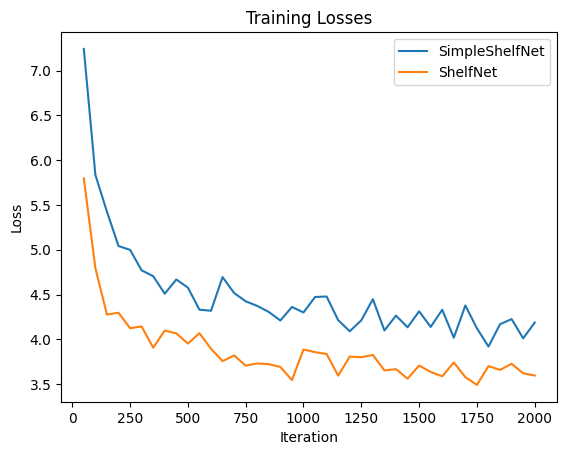

In [9]:
import matplotlib.pyplot as plt
import json

with open('./res/loss_1999.json', 'r') as f:
    loss_iters1 = json.load(f)

with open('./resOG/loss_1999.json', 'r') as f:
    loss_iters2 = json.load(f)

def plot_loss(loss1, loss2):
    x = np.arange(0+50, len(loss1)*50+1, msg_iter)
    plt.plot(x, np.array(loss1), label='SimpleShelfNet')
    plt.plot(x, np.array(loss2), label='ShelfNet')
    plt.title('Training Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(loss_iters1, loss_iters2)

### mIoU calculations on validation

In [3]:
from tqdm import tqdm

# validation dataset
batchsize = 2
n_workers = 2
ds_val = CityScapes('data/', mode='val')
dl_val = DataLoader(ds_val,
                batch_size = batchsize,
                shuffle = False,
                num_workers = n_workers,
                drop_last = False)

In [6]:
from evaluate import MscEval

# loading pretrained weights
net = SimpleShelfNet(n_classes=19, channel_ratio=.25)
net.load_state_dict(torch.load('res/model_final.pth'))
net.cuda()
net.eval()

# evaluate via mIoU
mEval = MscEval(net, dl_val, flip=False)
mIoU = mEval.evaluate()
print(f'mIoU: {mIoU}')

100%|██████████| 134/134 [01:14<00:00,  1.81it/s]

mIoU: 0.1925324770573541


In [7]:
# load original realtime model
net2 = ShelfNet(n_classes=19)
net2.load_state_dict(torch.load('resOG/model_final.pth'))
net2.cuda()
net2.eval()

# evaluate via mIoU
mEval = MscEval(net2, dl_val, flip=False)
mIoU = mEval.evaluate()
print(f'mIoU: {mIoU}')

100%|██████████| 134/134 [01:14<00:00,  1.81it/s]

mIoU: 0.39266715616147235


### Visualize results

In [31]:
# Define the helper function
def decode_segmap(image, nc=19):  
    label_colors = np.array([(128, 64,128),
                             
                (244, 35,232), ( 70, 70, 70), (102,102,156), (190,153,153), (153,153,153),
               
                (250,170, 30), (220,220,  0), (107,142, 35), (152,251,152), ( 70,130,180),
            
                (220, 20, 60), (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
        
                (  0, 80,100), (  0,  0,230), (119, 11, 32)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

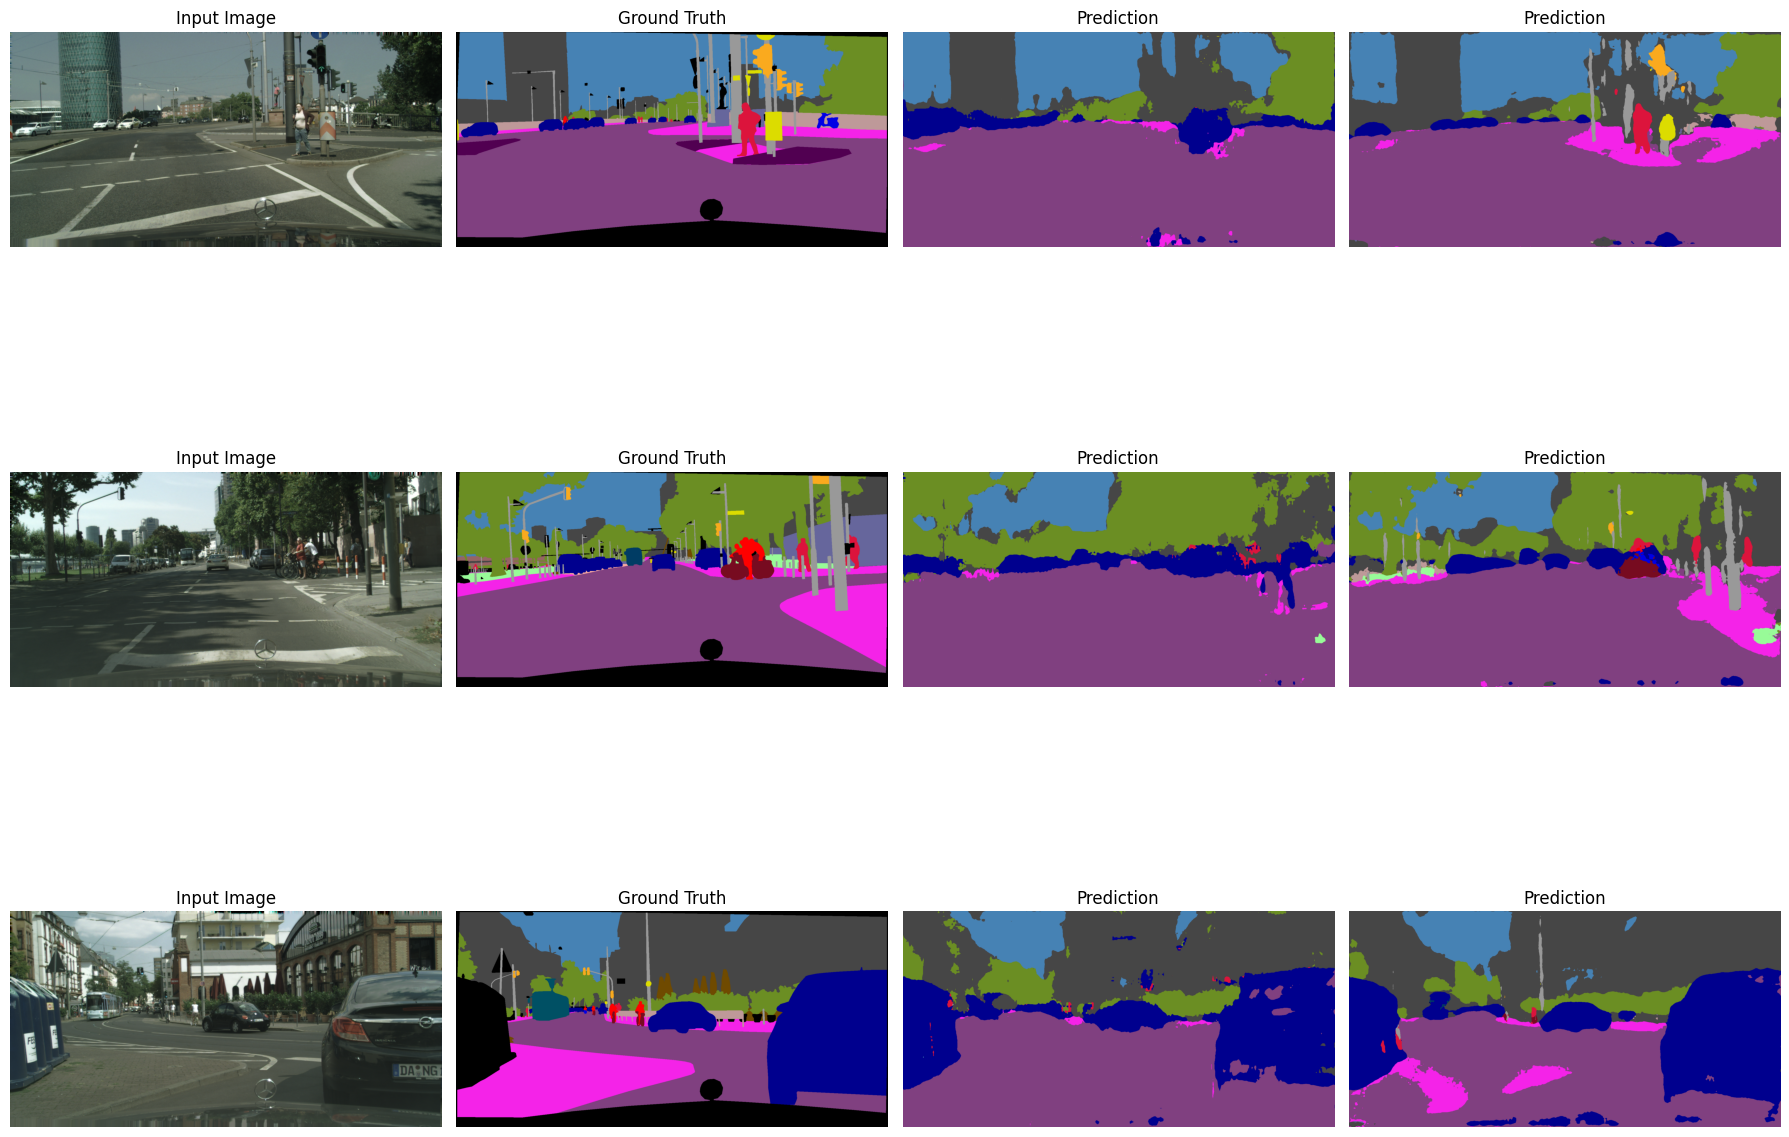

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms

# get original images without transforms
city_dataset = datasets.Cityscapes('data/', split='val', mode='fine', target_type=['instance', 'color', 'polygon'])

# Plot some images
num_samples = 3
fig, axs = plt.subplots(num_samples, 4, figsize=(18, num_samples * 5))

for i, ((im, (inst, col, poly)), (im2, lb)) in enumerate(zip(city_dataset, ds_val)):
    # get output from the model
    with torch.no_grad():
        output = net(im2[None].cuda(), aux=False)
        output2 = net2(im2[None].cuda(), aux=False)

    # get output
    om = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    om2 = torch.argmax(output2.squeeze(), dim=0).detach().cpu().numpy()
    

    # show the input image as a picture
    # Plot input image
    axs[i, 0].imshow(im)
    axs[i, 0].set_title('Input Image')
    axs[i, 0].axis('off')

    # Plot ground truth mask
    axs[i, 1].imshow(col)
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(decode_segmap(om))
    axs[i, 2].set_title('Prediction')
    axs[i, 2].axis('off')

    axs[i, 3].imshow(decode_segmap(om2))
    axs[i, 3].set_title('Prediction')
    axs[i, 3].axis('off')

    if i == num_samples - 1:
        break

plt.tight_layout()
plt.show()